# Network Creation

In [1]:
#!pip install torch ./Gym-Wordle

In [2]:
import torch
import matplotlib.pyplot as plt
from torch import normal

In [3]:
from torch import nn

class ActorNetwork(nn.Module):
    """LSTM RNN for generating words for wordle solver"""
    def __init__(self, input_size, output_size=2):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, output_size),
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        y = self.network(x)
        return y

class CriticNet(nn.Module):
    """Network representing the critic"""
    def __init__(self, in_shape):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_shape, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
            )

    def forward(self, x):
        return self.network(x)

# Figuring out the environment

In [4]:
import gym
import gym_wordle.utils
import numpy as np
wordle = gym.make('Wordle-v0')

# Use entropy minimization for reward function

In [5]:
entropies = list()
def entropy_critic(guess: np.ndarray, remaining_space: np.ndarray):
	# get guess and the values
	split = np.split(guess, 2)
	g = split[0]
	vals = split[1]
	explored = set()

	# get complete matches (i.e. matches based on position)
	matches = np.argwhere(vals==1).flatten()
	for i in matches:
		remaining_space = remaining_space[np.nonzero(remaining_space[:, i] == g[i])] 
		explored.add(g[i])

	# find remaining words that this letter
	exists = np.argwhere(vals==2).flatten()
	for i in exists:
		if g[i] in explored:
			continue
		else:
			explored.add(g[i])
		e = np.full(remaining_space.shape[0], False)
		for j in range(5):
			if i == j or np.isin(j, matches):
				continue
			e = np.logical_or(e, remaining_space[:, j] == g[i])
		remaining_space = remaining_space[e]

	# we know what letters we DON'T have
	dne = np.argwhere(vals==3).flatten()
	for i in dne:
		if g[i] in explored:
			continue
		else:
			explored.add(g[i])
		e = np.full(remaining_space.shape[0], False)
		for j in range(5):
			if np.isin(j, matches):
				continue
			e = np.logical_or(e, remaining_space[:, j] == g[i])
		remaining_space = remaining_space[np.logical_not(e)]

	# do calc
	p = float(remaining_space.shape[0]) / float(wordle.action_space.n)
	entropy = -p * np.log2(p)
	entropies.append(entropy)
	return entropy

# A2C solver

In [6]:
class Advantage_ActorCritic():
    def __init__(self, world: gym.Env, policy_net: ActorNetwork, critic,
                 encoder, policy_alpha,  gamma, max_reward):
        # environment info
        self.world = world
        self.encoder = encoder
        self.max_reward = max_reward

        # actor and critic
        self.actor = policy_net
        self.critic = critic
        self.error_buffer = list()
        self.policy_optimizer = torch.optim.Adam(policy_net.network.parameters(), lr=policy_alpha)

        # training info
        self.gamma = gamma
        self.episodes = 0
        self.step = 0
        self.guesses = np.zeros(world.action_space.n)
        self.remaining = None

    def train(self, iterations):
        converged = False
        rewards = list()
        recents = torch.zeros(10)
        i = 0
        while not converged:
            r = self.episode()
            rewards.append(r)

            if i < 10:
                recents[i] = r
                i += 1

            else:
                recents.roll(-1, 0)
                recents[9] = r
            
            # convergence check
            if len(rewards) > 10 and recents.mean() >= self.max_reward:
                converged = True
            converged = True if iterations == self.episodes else False
        
        plt.plot(rewards)
        plt.show()

    def episode(self, training=True):
        done = False
        state = self.world.reset().copy()
        episode_reward = 0
        self.episodes += 1
        self.step = -1
        self.remaining = gym_wordle.utils.get_words("guess")
        while not done:
            self.step += 1
            # take on policy action
            encoded = nn.functional.one_hot(self.encoder(state), 27)
            dist = self.actor(encoded.to(torch.float32).flatten())

            action = normal(dist[0], dist[1])
            action *= 10000
            action = int(action.clip(0, self.world.action_space.n-1).round().item())
            self.guesses[action] += 1
            state_prime, reward, done, _ = self.world.step(action)

            # fill buffer
            self.error_buffer.append((state, state_prime, reward, dist))

            # prepare for next iteration
            episode_reward += reward
            state = state_prime.copy()
            if training:
                self.__net_update()

        return episode_reward

    # Actor error
    def policy_error(self, prob, error):
        log_probabs_tensor = prob.reshape(-1)
        return (-log_probabs_tensor * error).mean()

    def __net_update(self):
        # calculate error for policy and critic
        self.actor.network.zero_grad()

        state, state_prime, reward, prob = self.error_buffer.pop(0)
        loss1 = self.critic(state[self.step-1], self.remaining)
        loss2 = self.critic(state_prime[self.step], self.remaining)

        policy_error = self.policy_error(prob, loss2-loss1)

        # backprop
        policy_error.backward()
        nn.utils.clip_grad_norm_(self.actor.parameters(), 1e-2)
        self.policy_optimizer.step()

# Solving the Environment

In [7]:
critic = entropy_critic
actor = ActorNetwork(60*27, 2)
agent = Advantage_ActorCritic(wordle, actor, critic, 
lambda x: torch.tensor(x.flatten()).to(torch.int64), 1e-6, 0.9, -4)

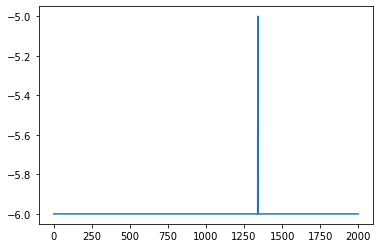

In [8]:
agent.train(2000)

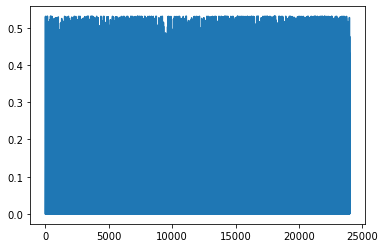

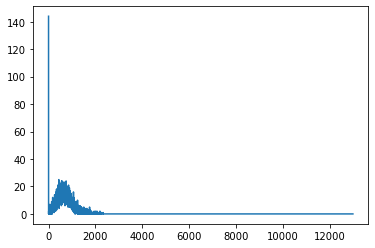

In [9]:
plt.plot(entropies)
plt.show()
plt.plot(agent.guesses)
plt.show()